 Alumnos: Cristhian Rodriguez y Jesus Perucha

# Practica 3:  Titanic

In [165]:
%matplotlib inline
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Importamos los datos para entrenar y testear

In [166]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#### Miramos los datos, para ver que si hay nulos o datos que rellenar, como la edad y la cabina en este caso

In [167]:
print(train_df.columns.values)
train_df.isnull().sum()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Faltan muchos datos de edad y cabina por rellenar, ademas de 2 embarcos

#### Miramos los tipos de los datos

In [168]:
print (train_df.info())
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Como faltan mas de la mitad de los datos de la cabina y no contienen informacion util, se puede descartar esta feature.

Tambien vamos a quitar ticket, porque no hay relacion ninguna entre los nombres de los tickets

In [169]:
train_df, test_df = train_df.drop(['Cabin', 'Ticket'], axis=1), test_df.drop(['Cabin', 'Ticket'], axis=1)

In [141]:
# Sacamos la descripcion de los valores que son Strings (object)
train_df.describe(include=['O'])

,Name,Sex,Embarked
count,891,891,889
unique,891,2,3
top,"Graham, Mr. George Edward",male,S
freq,1,577,644


## Analisis a primera vista de los datos

- Hay que rellenar los datos que faltan para poder usarlo en los algoritmos de entrenamiento
- Hay que pasar todos los strings a valores numericos para poder usarlo en los algoritmos de entrenamiento
- Hay que descartar features que sean inutiles o crear nuevas features a partir de las nuevas para entrenar

# Visualizacion grafica de la relacion entre las features

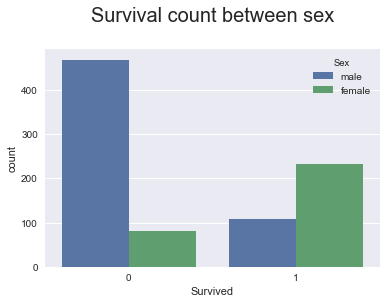

In [170]:
plt.title('Survival count between sex', size=20, y=1.1)
sns.countplot(x = 'Survived', hue='Sex', data=train_df)
#Hay una gran correlacion entre el sexo y la supervivencia

In [171]:
# Pasamos el sexo de string a un int, 1 para hombre y 0 para mujer
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].apply(lambda x : 1 if x == 'male' else 0)

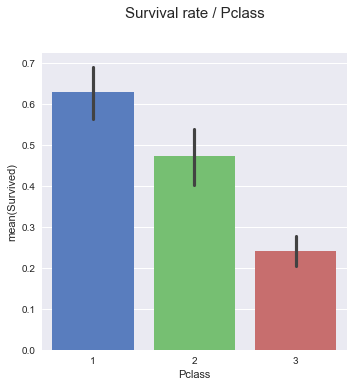

In [172]:
# Hay relacion directa entre la clase y la supervivencia
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.title('Survival rate / Pclass', size=15, y=1.1)
sns.barplot(x='Pclass', y = 'Survived', data=train_df, palette='muted')

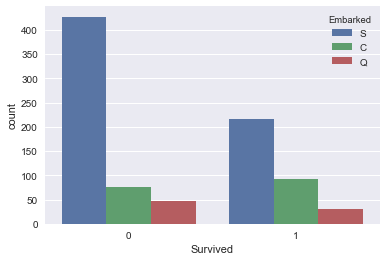

In [173]:
sns.countplot(x = 'Survived', hue='Embarked', data=train_df)
# Tambien hay una ligera correlacion con el lugar de embarque

Como faltan 2 datos de embarque de 2 personas y usaremos la feature, rellenamos con S porque 
es donde la mayoria de las personas lo han hecho y hay menos riesgo de falsear las features.
Tambien pasamos de S,C,Q a valores enteros para entrenarlos


In [174]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
for dt in [train_df, test_df]:
    dt['Embarked'] = dt['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [175]:
#Rellenamos el unico valor que falta de fare
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [176]:
# Transformamos los valores continuos de fare en valores discretos, agrupando los rangos en 4 grupos, del 0 al 3
for df in [train_df, test_df]:
    df['Fare'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,3,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,3,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,1,0


Como Parch es la abreviacion de 'parent/children', sumado y SibSp es la abreviacion de 'sibling/spouse' sumados, se pueden juntar estas 2 features en una sola que representen el tamaño de la familia que tiene esa persona, incluyendola.
Sacamos la grafica para ver la relacion que hay

In [177]:
for df in [train_df, test_df]:
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

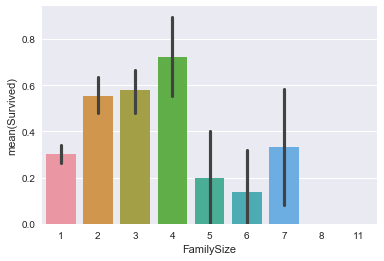

In [178]:
sns.barplot(x='FamilySize', y='Survived' , data=train_df)


De esta grafica podemos ver que las personas con 2,3 o 4 de tamaño familiar, tenian mas posibilidades de supervivencia
Asi que vamos a simplicar esta nueva feature en 0 si esta fuera de 2,3 o 4 miembros en el barco y 1 si lo esta.
Con esto las features Parch y SibSp no hacen falta

In [151]:
def filter_family_size(x):
    if x == 1:
        return 0
    elif x < 4:
        return 1
    else:
        return 0

for df in [train_df, test_df]:
    df['FamilySize'] = df['FamilySize'].apply(filter_family_size)


In [179]:
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)

In [180]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,3,1,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,3,0,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,1,0,1


# Rellenar la edad
La forma mas precisa de hacerlo es usando la mediana y la correlaciones que la edad tiene con otras features,en este caso las mas correladas son el genero y pclass, como se ve en el diagrama de calor de abajo.

A partir de la edad he creado una nueva feature con el rango de edades, para ver la supervivencia entre rangos

('El numero de datos Age sin rellenar: ', 177)


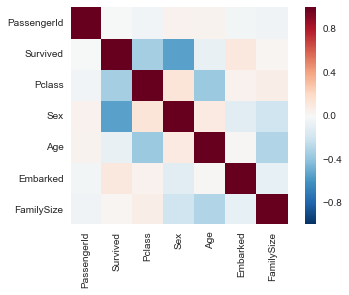

In [181]:
corrmat = train_df.corr()
sns.heatmap(corrmat, square=True)
print ("El numero de datos Age sin rellenar: ",train_df['Age'].isnull().sum())

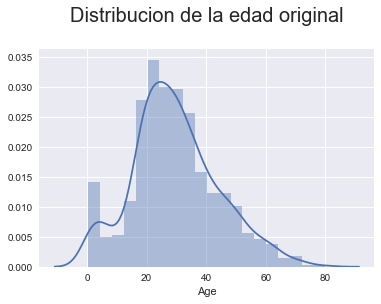

In [182]:
plt.title('Distribucion de la edad original', size=20, y=1.1)
sns.distplot(train_df['Age'].dropna())

In [183]:
#Rellenamos los campos edad vacios
guess_ages = np.zeros((2,3))
for dataset in [train_df, test_df]:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

print ("El numero de datos Age sin rellenar: ",train_df['Age'].isnull().sum())

('El numero de datos Age sin rellenar: ', 0)


Al haber introducido los nuevos datos sobre la media, la distribucion sigue siendo igual a antes de introducirlos, pero con un repunte de datos en la zona de la mediana

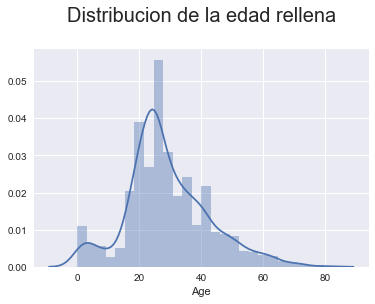

In [184]:
plt.title('Distribucion de la edad rellena', size=20, y=1.1)
sns.distplot(train_df['Age'])

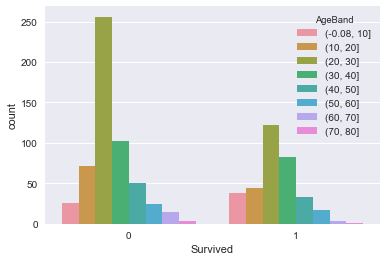

In [185]:
#Creamos la nueva feature y la mostramos
train_df['AgeBand'] = pd.cut(train_df['Age'], 8)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
sns.countplot(x='Survived', hue='AgeBand' , data=train_df)

Convertimos el campo edad en valores de 0 al 7 siguiendo la feature banda de edades que hemos creado antes, con este cambio, banda de edades es una feature que no necesitamos ya

In [186]:
for dataset in [train_df, test_df]:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 70, 'Age'] = 7
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",1,2,0,0,2,"(20, 30]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,3,1,2,"(30, 40]"
2,3,1,3,"Heikkinen, Miss. Laina",0,2,1,0,1,"(20, 30]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,3,0,2,"(30, 40]"
4,5,0,3,"Allen, Mr. William Henry",1,3,1,0,1,"(30, 40]"


In [187]:
train_df = train_df.drop(['AgeBand'], axis=1)


# Clasificamos el nombre segun el titulo de una persona

In [188]:
# Filter the name
def get_title(x):
    y = x[x.find(',')+1:].replace('.', '').replace(',', '').strip().split(' ')
    if y[0] == 'the':    # Search for the countess
        title = y[1]
    else:
        title = y[0]
    return title

def filter_title(title, sex):
    if title in ['Countess', 'Dona', 'Lady', 'Jonkheer', 'Mme', 'Mlle', 'Ms', 'Capt', 'Col', 'Don', 'Sir', 'Major', 'Rev', 'Dr']:
        if sex:
            return 'Rare_male'
        else:
            return 'Rare_female'
    else:
        return title

for df in [train_df, test_df]:
    df['NameLength'] = df['Name'].apply(lambda x : len(x))
    df['Title'] = df['Name'].apply(get_title)
    


In [189]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    

In [190]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize,NameLength,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,2,0,0,2,23,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,3,1,2,51,3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,2,1,0,1,22,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,3,0,2,44,3.0
4,5,0,3,"Allen, Mr. William Henry",1,3,1,0,1,24,1.0


Title
1.0    517
2.0    182
3.0    125
4.0     40
0.0     27
Name: PassengerId, dtype: int64

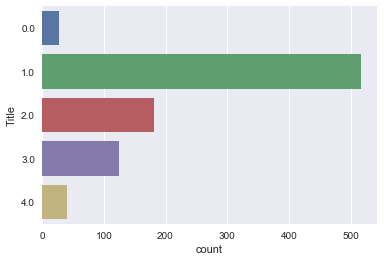

In [191]:
#Quitamos los titulos especiales y los agrupamos en categorias mas concretas
for df in [train_df, test_df]:
    df['Title'] = df.apply(lambda x: filter_title(x['Title'], x['Sex']), axis=1)

sns.countplot(y=train_df['Title'])
train_df.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

In [192]:
# Borramos la columna Name
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)


# Eleccion del Modelo

In [193]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891L,), (418, 8))

In [194]:
# Random Forest

X_train = train_df.drop(['Survived'], axis=1)
Y_train = train_df["Survived"]

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

96.52

##  Creamos el archivo submission para subir a kaggle

In [195]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })


## Lo guardamos en formato csv

In [196]:
submission.to_csv('submission.csv', index=False)